In [3]:
!qbraid jobs enable qiskit

You have already enabled qBraid Quantum Jobs in the qiskit environment.


In [69]:
import qiskit
from qiskit import QuantumCircuit, assemble, Aer
from math import pi, sqrt
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit.circuit.library import XXPlusYYGate
from qiskit import *
from qiskit import transpile
from itertools import combinations as combs
import scipy
from scipy import *
from IPython.display import clear_output
import matplotlib.pyplot as plt
from qiskit.algorithms.optimizers import SPSA
sim = Aer.get_backend('qasm_simulator')

In [80]:
def scorer(counts,edges):
    def score_k(k,edges):
        sum1=0
        # added_list=[[] for _ in k]
        # for edge in edges:
        #     v_i=edge[0]
        #     v_j=edge[1]
        #     if k[v_i]=='1' and v_j not in added_list[v_i] :
        #         added_list[v_i].append(v_j)
        #         sum1+=1
        #         if k[v_j]=='1':
        #             added_list[v_j].append(v_i)
        #     if k[v_j]=='1' and v_i not in added_list[v_j] :
        #         added_list[v_j].append(v_i)
        #         sum1+=1
        for edge in edges:
            sum1 += int(k[edge[0]])|int(k[edge[1]])
        return sum1
    
    # dic=dict()
    tot_score = 0
    # if '0000' in counts:
    #     print(counts['0000'])
    for k in counts.keys():
        #print(k,score_k(k,edges))
        scr=score_k(k,edges)
        # if scr not in dic:
        #     dic[scr]=0
        # dic[scr]+=counts[k]
        tot_score += counts[k]/sum(counts.values())*scr
    # print(dic)
    return tot_score
                    
def pH(alpha,qc,edges):
    for v_i,v_j in edges:
        qc.rz(alpha,v_i)
        qc.rz(alpha,v_j)
        qc.cx(v_i,v_j)
        qc.rz(alpha,v_j)
        qc.cx(v_i,v_j)
        

def mH(beta,qc):
    for v_i,v_j in list(combs([x for x in range(qc.num_qubits)],2)):
        qc.append(XXPlusYYGate(beta),[v_i,v_j])

def hamiltonian_evolution_score(alpha_beta_list,args):
    qc = args[0]
    edges = args[1]
    alpha_list = alpha_beta_list[:len(alpha_beta_list)//2]
    beta_list = alpha_beta_list[len(alpha_beta_list)//2:]
    for a,b in zip(alpha_list,beta_list):
        pH(a,qc,edges)
        mH(b,qc)
    qc.measure([x for x in range(qc.num_qubits)],[x for x in range(qc.num_qubits)])
    counts = execute(qc,sim,shots=1000).result().get_counts(qc)
    score = scorer(counts,edges)
    # print(score)
    return score

info = []

def callback(x):
    info.append(hamiltonian_evolution_score(x,[circ,edges]))
    plt.plot(info)
    plt.show()
    clear_output(wait=True)
    # return hamiltonian_evolution_score(x,[qc,edges])

def solver(qc,edges):
    alpha_list = [1,2]
    beta_list = [1,0]
    a_b_new = scipy.optimize.minimize(hamiltonian_evolution_score,alpha_list+beta_list,args=[qc,edges],callback=callback,method='Nelder-Mead')
    return a_b_new
     

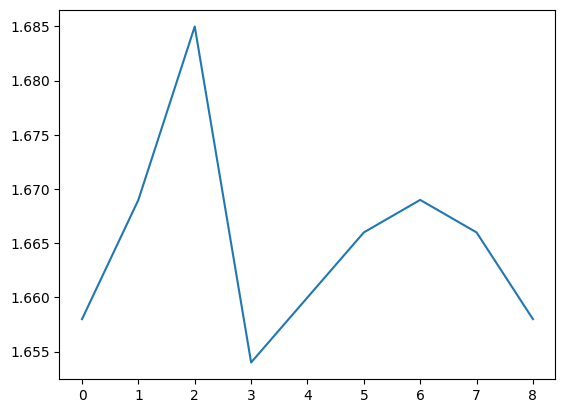

In [ ]:
global circ, edges
circ = QuantumCircuit(4,4)
circ.x(0)
circ.x(2)
edges = [[0,1],[2,3]]
#print(hamiltonian_evolution_score([1,2,1,0],[circ,edges]))
circ = solver(circ,edges)

counts = execute(circ,sim,shots=1000).result().get_counts(circ)
print(counts)
print(scorer(counts,[[0,1],[2,3]]))
# circ.draw()

In [ ]:
from qiskit.circuit.library import XXPlusYYGate
from qiskit import transpile

In [ ]:
circ = QuantumCircuit(2)
circ.append(XXPlusYYGate(1.3),[0,1])
circ = transpile(circ,basis_gates=['id','x','rz','sx','cx'])
circ.draw('mpl')